In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import numpy as np
import xarray as xr

from nowcast.nowcast import gaussian, multi_wave, hat

# Advection Equation

Given an initial tracer field and a constant background wind field, solve the two dimensional advection equation 

$$ \frac{\partial q}{\partial t} + \nabla\cdot(q\mathbf{u})= 0 $$

where $q$ is some scalar field and $\mathbf{u}$ is the velocity vector field, and $\nabla\cdot()$ is the divergence operator. For an incompressible flow such that

$$\nabla\cdot\mathbf{u} = 0$$

then the entire system simplifies to

$$ \frac{\partial q}{\partial t} + \mathbf{u}\cdot\nabla q = 0 $$

Furthermore, for a steady flow,

$$ \mathbf{u}\cdot\nabla q = 0 $$

which implies that $q$ is constant along a streamline, and that

$$\frac{\partial q}{\partial t} = 0$$

In general, this is a "hard" problem to solve numerically, since it forms a hyperbolic PDE. Instead of implementing an advection solver ourselves, we will instead defer to [ClawPack](http://www.clawpack.org/), which implements a suite of finite-volume solvers which should be suitable for this task (reference [2D advection solver](http://www.clawpack.org/pyclaw/gallery/advection_2d.html))

## `ClawPack` Testing

In [32]:
from clawpack import riemann
from clawpack import pyclaw

# rp = riemann.advection_2D
rp = riemann.vc_advection_2D
solver = pyclaw.SharpClawSolver2D(rp)
# solver = pyclaw.ClawSolver2D(rp)
# solver.limiters = pyclaw.limiters.tvd.vanleer
solver.bc_lower[0] = pyclaw.BC.extrap
solver.bc_upper[0] = pyclaw.BC.extrap
solver.bc_lower[1] = pyclaw.BC.extrap
solver.bc_upper[1] = pyclaw.BC.extrap

solver.aux_bc_lower[0] = pyclaw.BC.extrap
solver.aux_bc_upper[0] = pyclaw.BC.extrap
solver.aux_bc_lower[1] = pyclaw.BC.extrap
solver.aux_bc_upper[1] = pyclaw.BC.extrap

# Register domain
dx, dy = 500., 500.
nx, ny = 200, 50
x = pyclaw.Dimension(0, dx*nx, nx, name='x')
y = pyclaw.Dimension(0, dy*ny, ny, name='y')
domain = pyclaw.Domain([x, y])

x1d = domain.grid.x.centers
y1d = domain.grid.y.centers
xx = domain.grid.c_centers[0]
yy = domain.grid.c_centers[1]

num_eqn = 1
state = pyclaw.State(domain, num_eqn, num_aux=2)

# For non-vc
# state.problem_data['u'] = 10. # m/s
# state.problem_data['v'] = 1. # m/s

# For variable-coefficient
u = 20.*np.ones_like(yy)  # m/s
# u = 4.*multi_wave(xx, yy)
# v = 0.*np.ones_like(yy)  # m/s
v = -8.*np.cos(2.*np.pi*(1./(xx.max()/2.))*xx)
state.aux[0,...] = u
state.aux[1,...] = v

# q = gaussian(xx, yy, A=50., x0=10.*1000, y0=12.5*1000, sigmax=5.*1000., sigmay=7*1000)
# q[q < 20] = 0.0

q = hat(xx, yy, 50., [2500, 7500], [7500, 15000])

state.q[0,...] = q
plt.pcolormesh(xx, yy, q, vmin=0, vmax=50)
plt.quiver(xx[10::20,2::5], yy[10::20,2::5], u[10::20,2::5], v[10::20,2::5], 
           units='xy', angles='xy', scale_units='xy', pivot='middle')

ModuleNotFoundError: No module named 'clawpack'

In [164]:
claw = pyclaw.Controller()
claw.tfinal = 3600.
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver
claw.keep_copy = True

t_out = np.arange(0, 3601, 5*60)
claw.out_times = t_out
claw.num_output_times = len(t_out) - 1

In [165]:
claw.run()

2017-11-01 21:08:20,107 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:08:21,710 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-01 21:08:23,090 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-01 21:08:24,473 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-01 21:08:25,848 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-01 21:08:27,228 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-01 21:08:27,482 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-01 21:08:27,959 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-01 21:08:28,233 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-01 21:08:28,764 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-01 21:08:29,365 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-01 21:08:29,898 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-01 21:08:30,573 INFO CLAW: Solution 12 computed for time t=3

{'cflmax': 2.4500000000000006,
 'dtmax': 61.250000000000014,
 'dtmin': 61.249999999999993,
 'numsteps': 61}

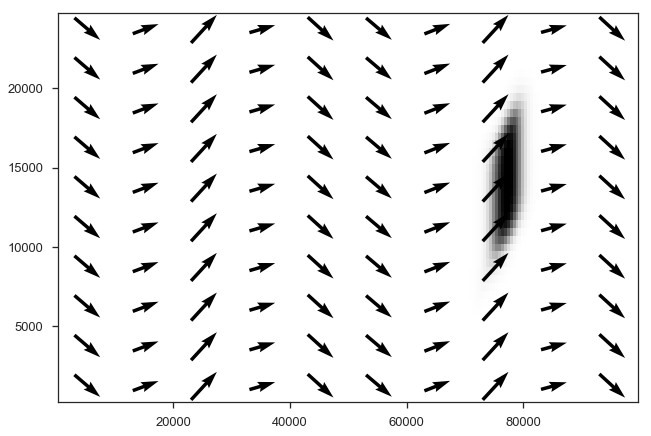

In [166]:
frames = claw.frames
plt.pcolormesh(xx, yy, frames[-1].q[0], vmin=0, vmax=50)
plt.quiver(xx[10::20,2::5], yy[10::20,2::5], u[10::20,2::5], v[10::20,2::5], 
           units='xy', angles='xy', scale_units='xy', pivot='middle')

In [7]:
times = claw.out_times
tracers = [f.q.squeeze() for f in claw.frames]
tracers = np.asarray(tracers)

ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), tracers),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': times, 'x': x1d, 'y': y1d},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf("test_cases/test_advection.nc")

NameError: name 'claw' is not defined

Note that in 1D with constant winds, the advection problem is dramatically simplified and analytically tractable, although we can always use numerical methods for simplicity:

$$\frac{\partial q}{\partial t} + u(x,t)\frac{\partial q}{\partial x} = 0$$

A simple test function $q(x, t)$ for which we can analytically solve this equation is the following time-shifting gaussian curve:

$$ q(x, t) = \exp\left( -\frac{(x - x_0) - ut}{L^2} \right) $$

where we've assumed a constant (in time and space) $u$.

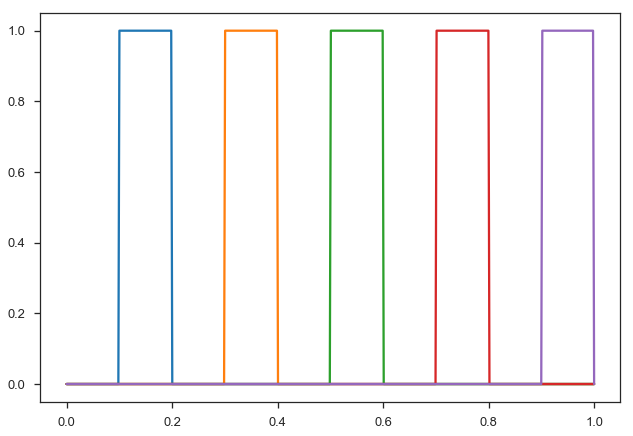

In [3]:
from functools import partial
from nowcast import gauss_1d, hat_1d

_g = partial(gauss_1d, x0=0.15, L=0.025, u=0.2, A=1)
_h = partial(hat_1d, x0=0.15, dx=0.05, u=0.2, A=1)

xs = np.linspace(0, 1, 500)
for i in range(5):
    ys = _h(xs, i)
    plt.plot(xs, ys, label=i)

Solve these same simulations using `ClawPack`

In [25]:
from functools import partial

from clawpack import riemann
from clawpack import pyclaw

import numpy as np
import xarray as xr

sharp = False
nx = 200
dx = 500

u = 10.
# qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)

rp = riemann.advection_1D
if sharp:
    solver = pyclaw.SharpClawSolver1D(rp)
    solver.weno_order = 5
else:
    solver = pyclaw.ClawSolver1D(rp)
    
solver.bc_lower[0] = pyclaw.BC.periodic
solver.bc_upper[0] = pyclaw.BC.periodic

x = pyclaw.Dimension(0, dx*nx, nx, name='x')
domain = pyclaw.Domain(x)

state = pyclaw.State(domain, solver.num_eqn)
state.problem_data['u'] = u

x1d = domain.grid.x.centers
q = qfunc(x1d, t=0)

state.q[0, ...] = q

In [26]:
claw = pyclaw.Controller()
claw.keep_copy = True
claw.solution = pyclaw.Solution(state, domain)
claw.solver = solver

t_out=np.arange(0, 3601, 5*60)
claw.tfinal = t_out[-1]
claw.out_times = t_out
claw.num_output_times = len(t_out) - 1

In [27]:
claw.run()

times = claw.out_times
tracers = [f.q.squeeze() for f in claw.frames]
tracers = np.asarray(tracers)

2017-11-02 10:48:28,061 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-02 10:48:28,067 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-02 10:48:28,076 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-02 10:48:28,084 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-02 10:48:28,093 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-02 10:48:28,101 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-02 10:48:28,110 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-02 10:48:28,118 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-02 10:48:28,130 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-02 10:48:28,138 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-02 10:48:28,146 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-02 10:48:28,156 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-02 10:48:28,164 INFO CLAW: Solution 12 computed for time t=3

In [28]:
uarr = u*np.ones_like(x1d)

ds = xr.Dataset(
    {'q': (('time', 'x'), tracers),
     'u': (('x', ), uarr)},
    {'time': times, 'x': x1d}
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

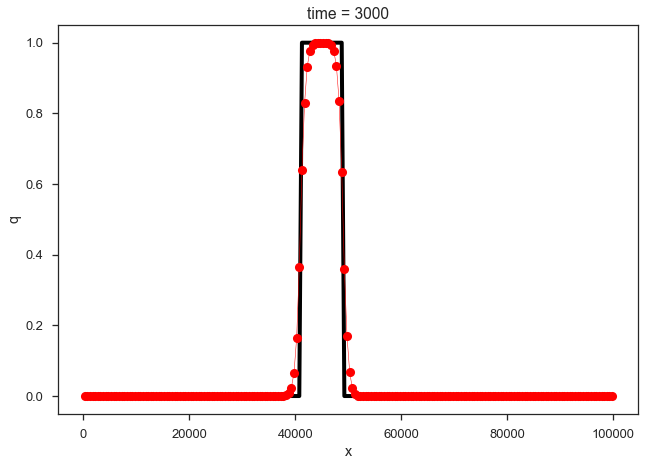

In [30]:
it = 10
t = float(ds.time.isel(time=it))
qref = qfunc(ds.x, t)


plt.plot(ds.x, qref, lw=4, color='k')
ds.q.isel(time=it).plot(lw=0.5, color='r', marker='o')

## 1D Cases

In [20]:
from nowcast.advection import advect_1d
from nowcast import hat_1d, gauss_1d

import numpy as np

nx = 400
dx = 500.

u = 10.
qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, dx=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 3601, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/hat_1d.nc")

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, dx=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 7201, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/hat_1d.long.nc")

###

u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, L=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 3601, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.nc")

ds = advect_1d(10., qfunc, dict(t=0, x0=15*1000, L=4*1000, u=u, A=1.),
               nx=nx, dx=dx, t_out=np.arange(0, 7201, 5*60), sharp=True)
ds['q_analytic'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.long.nc")

2017-11-02 17:55:33,070 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-02 17:55:33,079 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-02 17:55:33,087 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-02 17:55:33,096 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-02 17:55:33,111 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-02 17:55:33,121 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-02 17:55:33,134 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-02 17:55:33,147 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-02 17:55:33,157 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-02 17:55:33,171 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-02 17:55:33,181 INFO CLAW: Solution 10 computed for time t=3000.000000
2017-11-02 17:55:33,191 INFO CLAW: Solution 11 computed for time t=3300.000000
2017-11-02 17:55:33,205 INFO CLAW: Solution 12 computed for time t=3

## 1D - Additional

In [ ]:
u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
# ds = xr.open_dataset("test_cases/gauss_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/gauss_1d.analytical.long.nc")

In [21]:
# u = 10.
# qfunc = partial(hat_1d, x0=15*1000, dx=4*1000, u=u, A=1.)
# ds = xr.open_dataset("test_cases/hat_1d.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/hat_1d.analytical.nc")

# ds = xr.open_dataset("test_cases/hat_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/hat_1d.analytical.long.nc")


u = 10.
qfunc = partial(gauss_1d, x0=15*1000, L=4*1000, u=u, A=1.)
ds = xr.open_dataset("test_cases/gauss_1d.nc").copy()
ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
ds.to_netcdf("test_cases/gauss_1d.analytical.nc")

# ds = xr.open_dataset("test_cases/gauss_1d.long.nc").copy()
# ds['q'] = (('time', 'x'), np.asarray([qfunc(ds.x, float(t)) for t in ds.time]))
# ds.to_netcdf("test_cases/gauss_1d.analytical.long.nc")


## 2D Cases

In [12]:
from nowcast.advection import advect_field
from nowcast import hat, gaussian, min_gaussian

import numpy as np

MIN_VAL = 0.01

ds = advect_field(10., 0., 
                  hat, dict(A=1., xbnds=[2500, 7500], ybnds=[7500, 15000]),
                  t_out=np.arange(0, 3201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/hat.linear.nc")

ds = advect_field(10., 0., 
                  hat, dict(A=1., xbnds=[2500, 7500], ybnds=[7500, 15000]),
                  t_out=np.arange(0, 7601, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/hat.linear.long.nc")

ds = advect_field(10., 0., 
                  min_gaussian, 
                  dict(minimum=MIN_VAL, A=1., x0=10.*1000, y0=12.5*1000, 
                       sigmax=1.75*1000., sigmay=3*1000),
                  t_out=np.arange(0, 3201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/blob.linear.nc")

ds = advect_field(10., 0., 
                  min_gaussian, 
                  dict(minimum=MIN_VAL, A=1., x0=10.*1000, y0=12.5*1000, 
                       sigmax=1.75*1000., sigmay=3*1000),
                  t_out=np.arange(0, 7201, 5*60),
                  sharp=False)
ds = ds.where(ds > MIN_VAL)
ds.to_netcdf("test_cases/blob.linear.long.nc")

2017-11-01 21:50:36,445 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:50:36,474 INFO CLAW: Solution 1 computed for time t=300.000000
2017-11-01 21:50:36,503 INFO CLAW: Solution 2 computed for time t=600.000000
2017-11-01 21:50:36,533 INFO CLAW: Solution 3 computed for time t=900.000000
2017-11-01 21:50:36,563 INFO CLAW: Solution 4 computed for time t=1200.000000
2017-11-01 21:50:36,592 INFO CLAW: Solution 5 computed for time t=1500.000000
2017-11-01 21:50:36,629 INFO CLAW: Solution 6 computed for time t=1800.000000
2017-11-01 21:50:36,666 INFO CLAW: Solution 7 computed for time t=2100.000000
2017-11-01 21:50:36,702 INFO CLAW: Solution 8 computed for time t=2400.000000
2017-11-01 21:50:36,738 INFO CLAW: Solution 9 computed for time t=2700.000000
2017-11-01 21:50:36,770 INFO CLAW: Solution 10 computed for time t=3000.000000
(11, 200, 50) (200, 50) (200, 50) (200,)
2017-11-01 21:50:36,813 INFO CLAW: Solution 0 computed for time t=0.000000
2017-11-01 21:50:36,855 INFO CL

# Simple Advection Test

Here we implement a simple 2D linear advection solver and evaluate its performance on our test case.

In [405]:
import numpy as np
import xarray as xr

test_ds = xr.open_dataset("test_cases/test_advection.nc")

q0 = test_ds.q.isel(time=0).values
u = test_ds.u.values
v = test_ds.v.values

x = test_ds.x.values
y = test_ds.y.values

Δx = x[1] - x[0]
Δy = y[1] - y[0]

## 1st-order, Euler

We wish to numerically integrate the linear advection problem

$$\frac{\partial q}{\partial t} + u(x, t)\frac{\partial q}{\partial x} + v(x, t)\frac{\partial q}{\partial y} = 0$$

The simplest way to achieve this is to re-write the derivatives using finite differences, where we approximate $\frac{\partial q}{\partial x}$ as $\frac{\Delta q}{\Delta x}$, and solve on a grid of values, such that

$$\frac{\partial q}{\partial x} \approx \frac{\Delta q}{\Delta x} = \frac{q(x+\Delta x) - q(x)}{\Delta x}$$

It is trivial to show that a scheme which samples to the *upwind* portion of $q$ to approximate the spatial derivative $\frac{\partial q}{\partial x} will be more stable (less prone to spurious numerical noise) than one which samples the downwind. For a first order finite difference (shown previously), we can compactly write the numerical estimate for the upwind derivative as

$$\frac{\partial q}{\partial x} \approx u^+\frac{q_i^n - q_{i-1}^n}{\Delta x} + u^-\frac{q_{i+1}^n - q_i^n}{\Delta x}$$

where 

$$ u^+ = \mathrm{max}(u, 0),\qquad u^-=\mathrm{min}(u,0) $$

With this general formulation, we can write a first-order in time, first-order in space, upwind advection scheme (FTFS-upwind)

$$u_{i,j}^{n+1} = u_{i,j}^{n} - \Delta t\left(
u^+\frac{q_{i,j}^n - q_{i-1,j}^n}{\Delta x} + u^-\frac{q_{i+1,j}^n - q_{i,j}^n}{\Delta x} + 
v^+\frac{q_{i,j}^n - q_{i,j-1}^n}{\Delta y} + v^-\frac{q_{i,j+1}^n - q_{i,j}^n}{\Delta y}
\right)$$

This scheme has a local stability crtierion such that numerical solutions are *conditionally stable* if 

$$\frac{u \Delta t}{\Delta x} \geq 0 $$

and

$$\frac{v \Delta t}{\Delta y} \geq 0 $$

and

$$\frac{u \Delta t}{\Delta x} + \frac{v \Delta t}{\Delta y} \leq 1$$


In [194]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 16
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

def deriv(q, u=u, v=v, Δx=Δx, Δy=Δy):

    _q = q.copy()
    
    dq_x_neg = _q[1:-1, 1:-1] - _q[ :-2, 1:-1]
    dq_x_pos = _q[2:,   1:-1] - _q[1:-1, 1:-1] 
    dq_y_neg = _q[1:-1, 1:-1] - _q[1:-1,  :-2]
    dq_y_pos = _q[1:-1,   2:] - _q[1:-1, 1:-1]
    
    u_pos = np.maximum(u, 0)[1:-1, 1:-1]
    u_neg = np.minimum(u, 0)[1:-1, 1:-1]
    v_pos = np.maximum(v, 0)[1:-1, 1:-1]
    v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    
    dq_x = (u_pos * dq_x_neg) + (u_neg * dq_x_pos)
    dq_y = (v_pos * dq_y_neg) + (v_neg * dq_y_pos)
    
    return dq_x/Δx + dq_y/Δy

qs = [q, ]
ts = [0, ]

oc = 0
for i in range(12 * yy):
    
    q_new = np.zeros_like(q)
    q_int = q[1:-1, 1:-1]
    q_new[1:-1, 1:-1] = q_int - Δt*deriv(q)
        
    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        oc += 1
        qs.append(q)
        ts.append(t)
        print(oc, t, q.max(), deriv(q).max())
    
qs = np.asarray(qs)
ts = np.asarray(ts)

1.04999070086
50.0
1 0.0 50.0 2.04585534374
2 300.0 49.844961043 0.612705728318
3 600.0 47.8877534278 0.354021072919
4 900.0 44.0591735421 0.260556498999
5 1200.0 39.6050239326 0.210771666818
6 1500.0 36.6946338386 0.180769494288
7 1800.0 34.2362185741 0.159915567586
8 2100.0 30.9253854425 0.137583193157
9 2400.0 27.9693360143 0.118381759635
10 2700.0 26.1675331651 0.105235445947
11 3000.0 24.9594206043 0.0967189196035
12 3300.0 23.1168413308 0.0871599701113


In [195]:
ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), qs),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.o1.nc')

## 1st-order, Dimensional usplitting, Euler

Also known as "corner transport upstream"


e.g. following [here](http://www.bu.edu/pasi-tsunami/files/2013/01/lecture3_DAC.pdf)

In [407]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 15
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

qs = [q, ]
ts = [0, ]

oc = 0
for i in range(12 * yy):
    
    q_new = np.zeros_like(q)
    nx, ny = q_new.shape

    _q = q.copy()
    
    u_pos = np.maximum(u, 0)[1:-1, :]
    u_neg = np.minimum(u, 0)[1:-1, :]
    dq_x_neg = _q[1:-1, :] - _q[ :-2, :]
    dq_x_pos = _q[2:,   :] - _q[1:-1, :] 
    
    qq = _q[1:-1] - (u_pos * dq_x_neg + u_neg * dq_x_pos)*Δt/Δx
    
    v_pos = np.maximum(v, 0)[1:-1, 1:-1]
    v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    dq_y_neg = qq[:, 1:-1] - qq[:,  :-2]
    dq_y_pos = qq[:,   2:] - qq[:, 1:-1]
    
    q_step = qq[:, 1:-1] \
           - (v_pos * dq_y_neg + v_neg * dq_y_pos)*Δt/Δy
    
    q_new[1:-1,1:-1] = q_step[:]
            
    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        oc += 1
        qs.append(q)
        ts.append(t)
        print(oc, t, q.max())
    
qs = np.asarray(qs)
ts = np.asarray(ts)

1.11999008091
50.0
1 0.0 50.0
2 300.0 49.987621118
3 600.0 48.9238777124
4 900.0 46.5546182731
5 1200.0 43.4556967988
6 1500.0 40.6684612387
7 1800.0 38.4958872895
8 2100.0 35.940267012
9 2400.0 33.4986003694
10 2700.0 31.5401651412
11 3000.0 30.1871128691
12 3300.0 28.4215055122


In [408]:
ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), qs),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.ctu.nc')

## 1st-order + RK2-TVD

First, take an Euler step to advanced the time to to $t^{n+1}$

$$\frac{q^{n+1} - q^n}{\Delta t} + \mathbf{u}^n\cdot\nabla q^n = 0$$

Then perofrm a second Euler step to advance the solution to $t^{n+2}$

$$\frac{q^{n+2} - q^{n+1}}{\Delta t} + \mathbf{u}^{n+1}\cdot\nabla q^{n+1} = 0$$

Finally, the two steps are combined:

$$q^{n+1} = \frac{q^n + q^{n+2}}{2}$$


In [201]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 16
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

def deriv(q, u=u, v=v, Δx=Δx, Δy=Δy):

    _q = q.copy()
    
    dq_x_neg = _q[1:-1, 1:-1] - _q[ :-2, 1:-1]
    dq_x_pos = _q[2:,   1:-1] - _q[1:-1, 1:-1] 
    dq_y_neg = _q[1:-1, 1:-1] - _q[1:-1,  :-2]
    dq_y_pos = _q[1:-1,   2:] - _q[1:-1, 1:-1]
    
    u_pos = np.maximum(u, 0)[1:-1, 1:-1]
    u_neg = np.minimum(u, 0)[1:-1, 1:-1]
    v_pos = np.maximum(v, 0)[1:-1, 1:-1]
    v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    
    dq_x = (u_pos * dq_x_neg) + (u_neg * dq_x_pos)
    dq_y = (v_pos * dq_y_neg) + (v_neg * dq_y_pos)
    
    return dq_x/Δx + dq_y/Δy

qs = [q, ]
ts = [0, ]

oc = 0
for i in range(12 * yy):
    
    # Step 1
    q1 = np.zeros_like(q)
    q1[1:-1, 1:-1] =q[1:-1, 1:-1] - Δt*deriv(q)
    
    # Step 2
    q2 = np.zeros_like(q1)
    q2[1:-1, 1:-1] = q1[1:-1, 1:-1] - Δt*deriv(q1)
    
    # Combo
    q_new = (q - q2)/2.
        
    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        oc += 1
        qs.append(q)
        ts.append(t)
        print(oc, t, q.max(), deriv(q).max())
        print(oc, t, q1.max(), q2.max())

qs = np.asarray(qs)
ts = np.asarray(ts)

1.04999070086
50.0
1 0.0 26.0600011004 1.37480999488
1 0.0 50.0 50.0
2 300.0 0.854872125075 0.0531001197141
2 300.0 0.884900605307 0.695708167779
3 600.0 0.0254965937154 0.00184774325892
3 600.0 0.0266457358733 0.0201478001976
4 900.0 0.00157262354621 0.000141013181021
4 900.0 0.00160913860193 0.00158293233738
5 1200.0 0.000862254057816 5.72359344095e-05
5 1200.0 0.000854363133174 0.000808930620713
6 1500.0 9.65311413078e-05 7.60113066516e-06
6 1500.0 9.71844272621e-05 8.20356690822e-05
7 1800.0 4.55566865241e-06 2.85237979289e-07
7 1800.0 4.32060063409e-06 3.33477302798e-06
8 2100.0 3.88069265636e-07 3.18666169746e-08
8 2100.0 3.90780236256e-07 3.92095931374e-07
9 2400.0 2.60007832453e-07 2.33813273452e-08
9 2400.0 2.63071012655e-07 2.56155039431e-07
10 2700.0 9.72829101955e-08 5.58514624049e-09
10 2700.0 9.83487190435e-08 8.64214009213e-08
11 3000.0 1.07580269858e-08 7.72320427489e-10
11 3000.0 1.07494516719e-08 8.89316059403e-09
12 3300.0 5.75510982409e-10 4.04055598763e-11
12 3300.

In [199]:
ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), qs),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.o1.rk2.nc')

## 2nd-order, Euler

Siimlar to the 1st-order method, except note that we include an additional term in the stencil for estimating the derivative. WLOG,

$$q^-=\frac{3q_i^n - 4q_{i-1}^n + q_{i-2}^n}{2\Delta x}$$

and

$$q^+=\frac{-q_{i+2}^n + 4q_{i+1}^n - 3 q_i^n}{2\Delta x}$$

A stability criterion for this scheme is much more involved to estimate.

In [179]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 200
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

qs = [q, ]
ts = [0, ]

for i in range(12 * yy + 1):
    q_int = q[2:-2, 2:-2]

    u_pos = np.maximum(u, 0)[2:-2, 2:-2]
    u_neg = np.minimum(u, 0)[2:-2, 2:-2]
    v_pos = np.maximum(v, 0)[2:-2, 2:-2]
    v_neg = np.minimum(v, 0)[2:-2, 2:-2]

    dq_x_neg =  3.*q[2:-2, 2:-2] - 4.*q[1:-3, 2:-2] +    q[ :-4, 2:-2]
    dq_x_pos = -1.*q[4:,   2:-2] + 4.*q[3:-1, 2:-2] - 3.*q[2:-2, 2:-2] 
    dq_y_neg =  3.*q[2:-2, 2:-2] - 4.*q[2:-2, 1:-3] +    q[2:-2,  :-4]
    dq_y_pos = -1.*q[2:-2, 4:  ] + 4.*q[2:-2, 3:-1] - 3.*q[2:-2, 2:-2]
    
    q_new = np.zeros_like(q)
    dq_x = (u_pos * dq_x_neg) + (u_neg * dq_x_pos)
    dq_y = (v_pos * dq_y_neg) + (v_neg * dq_y_pos)
    q_new[2:-2, 2:-2] = q_int - Δt*(dq_x/Δx/2 + dq_y/Δy/2)

    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        qs.append(q)
        ts.append(t)
        print(t, q.max(), (u_pos*dq_x_neg).max(), (v_pos*dq_y_neg).max())
    
qs = np.asarray(qs)
ts = np.asarray(ts)

0.0839992560685
50.0
0.0 52.0504085802 3000.0 0.0
300.0 64.6192670709 547.94120186 34.3276968303
600.0 62.2246341972 475.014867742 176.175321591
900.0 59.9542849723 405.097348267 202.996125888
1200.0 59.5617937799 327.262191882 139.144431494
1500.0 58.9944885683 300.282523342 40.1439514293
1800.0 57.2447456292 283.780259085 1.12057572131
2100.0 55.5128379988 275.806859088 0.88332201146
2400.0 55.2726545258 263.765984923 5.77054331202
2700.0 54.716727551 284.767728952 28.0705490827
3000.0 53.6371264103 291.897362603 83.5067068662
3300.0 53.0294926217 292.253906733 122.483966461
3600.0 52.6457052397 298.261882518 99.1494039907


In [159]:
ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), qs),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.o2.nc')

## Corner Transport (Upstream), Euler


In [329]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 2**4
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

# def deriv(q, u=u, v=v, Δx=Δx, Δy=Δy):

#     _q = q.copy()
#     u_pos = np.maximum(u, 0)[1:-1, 1:-1]
#     u_neg = np.minimum(u, 0)[1:-1, 1:-1]
#     v_pos = np.maximum(v, 0)[1:-1, 1:-1]
#     v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    
#     Cu_pos = u_pos*Δt/Δx
#     Cu_neg = u_neg*Δt/Δx
#     Cv_pos = v_pos*Δt/Δy
#     Cv_neg = v_neg*Δt/Δy
    
#     qs = (1. - Cu_pos)*q[1:-1,:] + Cu_pos*q[:-2, :] \
#        + (1. - Cu_neg)*q[2:,  :] + Cu_neg*q[1:-1,:]
#     q_step = (1. - Cv_pos)*qs[:,1:-1] + Cv_pos[:,  -2] \
#            + (1. - Cv_pos)*qs[:,  2:] + Cv_pos[:,1:-1]
    
#     return dq_x/Δx + dq_y/

qs = [q, ]
ts = [0, ]

oc = 0
for i in range(12 * yy):
    
    q_new = np.zeros_like(q)
    nx, ny = q_new.shape
    
#     Cu = u[1:-1,:]*Δt/Δx
#     Cv = v[1:-1,1:-1]*Δt/Δy
#     q_star = (1. - Cu)*q[1:-1,:] + Cu*q[:-2,:]
#     q_step = (1. - Cv)*q_star[:,1:-1] + \
#              Cv*q_star[:,:-2] 

    u_pos = np.maximum(u, 0)[1:-1, :]
    upm = u_pos != 0
    u_neg = np.minimum(u, 0)[1:-1, :]
    unm = u_neg != 0
    v_pos = np.maximum(v, 0)[1:-1, 1:-1]
    vpm = v_pos != 0
    v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    vnm = v_neg != 0
    
    Cu_pos = u_pos*Δt/Δx
    Cu_neg = u_neg*Δt/Δx
    Cv_pos = v_pos*Δt/Δy
    Cv_neg = v_neg*Δt/Δy
    
    qi = np.zeros((nx-2, ny))
    q_step = np.zeros((nx-2, ny-2))
    
    
    qip = (1. - Cu_pos)*q[1:-1,:] + Cu_pos*q[:-2, :] 
    qin = (1. - Cu_neg)*q[2:  ,:] + Cu_neg*q[1:-1,:] 
    qi = np.where(u_pos != 0, qip, qin)
    
    qsp = (1. - Cv_pos)*qi[:,1:-1] + Cv_pos*qi[:, :-2]
    qsn = (1. - Cv_neg)*qi[:,  2:] + Cv_neg*qi[:,  2:]
    q_step = np.where(v_pos != 0, qsp, qsn)
    
    print(qip.max(), qin.max())
    print(qsp.max(), qsn.max())

#     qi = np.zeros((nx-2, ny))
#     qi[unm] = (1. - Cu_neg[unm])*q[2:,:][unm] \
#             + (Cu_neg[unm])*q[1:-1, :][unm]
#     q_step[vnm] = (1. - Cv_neg[vnm])*qi[:,2:][vnm] \
#                 + (Cv_neg[vnm])*qi[:,1:-1][vnm]
    # print(q_step.max())
    
    q_new[1:-1,1:-1] = q_step[:]
            
    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        oc += 1
        qs.append(q)
        ts.append(t)
        print(oc, t, q.max())
    
qs = np.asarray(qs)
ts = np.asarray(ts)

1.04999070086
50.0
50.0 50.0
50.0 50.0
1 0.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
50.0 50.0
49.9999523163 50.0
49.9999523163 49.9999523163
49.9995946884 49.9999523163
49.9995946884 49.9995946884
49.9981194735 49.9995946884
49.9981194735 49.9981194735
49.9936938286 49.9981194735
49.9936938286 49.9936938286
49.9829063192 49.9936938286
49.9829063192 49.9829063192
49.9602525495 49.9829063192
49.9602525495 49.9602525495
49.9177767313 49.9602525495
49.9177767313 49.9177767313
49.844961043 49.9177767313
49.844961043 49.844961043
2 300.0 49.844961043
49.7289110397 49.844961043
49.7289110397 49.7289110397
49.6741644149 49.7289110397
49.6741644149 49.6741644149
49.6443323198 49.6741644149
49.6443323198 49.6443323198
49.5599440281 49.6443323198
49.5599440281 49.5599440281
49.4120879631 49.5599440281
49.4120879631 49.4120879631
49.1902045524 49.4120879631
49.1902045509 49.190204552

3.21898438114e-05 1.91769786785e-05
1.91694643182e-05 1.91769786785e-05
1.91694643182e-05 1.13891030685e-05
1.13189840441e-05 1.13891030685e-05
1.13189840441e-05 6.718084939e-06
6.68229933557e-06 6.718084939e-06
6.68229933557e-06 3.93037675396e-06
3.91872767246e-06 3.93037675396e-06
3.91872767246e-06 2.28097026416e-06
2.27963654153e-06 2.28097026416e-06
2.27963654153e-06 1.32282349505e-06
1.31567827271e-06 1.32282349505e-06
1.31567827271e-06 7.62983106246e-07
7.5878584924e-07 7.62983106246e-07
7.5878584924e-07 4.36718141028e-07
4.35321283755e-07 4.36718141028e-07
4.35321283755e-07 2.48094687832e-07
2.47875896794e-07 2.48094687832e-07
2.47875896794e-07 1.40712131115e-07
1.40103010061e-07 1.40712131115e-07
1.40103010061e-07 7.95079813394e-08
7.90428326778e-08 7.95079813394e-08
7.90428326778e-08 4.46039255255e-08
4.44424478717e-08 4.46039255255e-08
4.44424478717e-08 2.4846709233e-08
2.48124315465e-08 2.4846709233e-08
2.48124315465e-08 1.37930884386e-08
1.37570540922e-08 1.37930884386e-08


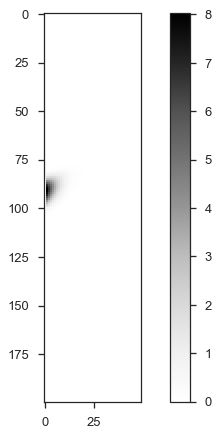

In [323]:
plt.imshow(qs[8])
plt.colorbar()

In [330]:
ds = xr.Dataset(
    {'q': (('time', 'x', 'y'), qs),
     'u': (('x', 'y'), u),
     'v': (('x', 'y'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name':
                      'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.cut.nc')

## Nir Method - 1st order

In [ ]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 1
Δt = 300.0 / yy
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

qs = [q, ]
ts = [0, ]

for i in range(12 * yy + 1):
    q_new = q.copy()
    
    xshift = u[1:-1,1:-1]*Δt
    yshift = v[1:-1,1:-1]*Δt
    Wex = np.floor(xshift) + 1 - xshift
    Wlx = xshift - np.floor(xshift)
    Wey = np.floor(yshift) + 1 - yshift
    Wly = yshift - np.floor(yshift)
    
    
    

    q = q_new.copy()
    t = i*Δt
    
    if (t % 300) == 0:
        qs.append(q)
        ts.append(t)
        print(t, q.max(), (u_pos*dq_x_neg).max(), (v_pos*dq_y_neg).max())
    
qs = np.asarray(qs)
ts = np.asarray(ts)


# Pixel Shift Accounting

In [369]:
import numpy as np

hrrr = xr.open_dataset("data/boston_nov_3/hrrr/hrrr.ensemble.nc")
hrrr = hrrr.isel(lv_HTGL2=0)

Δx = 3e3 # m
Δy = 3e3 # m
Δt = 60*5 # s

u = hrrr.USTM_P0_2L103_GLC0
v = hrrr.VSTM_P0_2L103_GLC0

Δi = u * Δt / Δx
Δj = v * Δt / Δy

Wx = np.where(u > 0, Δi - np.floor(Δi), Δi - np.ceil(Δi))
Wx = np.ma.masked_invalid(Wx)
Wy = np.where(v > 0, Δj - np.floor(Δj), Δj - np.ceil(Δj))
Wy = np.ma.masked_invalid(Wy)


In [373]:
Wy.max()

0.74778137207031248

In [402]:
Wx_sample = np.dstack([Wx[i, i+1] for i in range(4)]).ravel()
Wy_sample = np.dstack([Wy[i, i+1] for i in range(4)]).ravel()

Δi_sample = np.dstack([Δi[i, i+1] for i in range(4)]).ravel()
Δj_sample = np.dstack([Δj[i, i+1] for i in range(4)]).ravel()

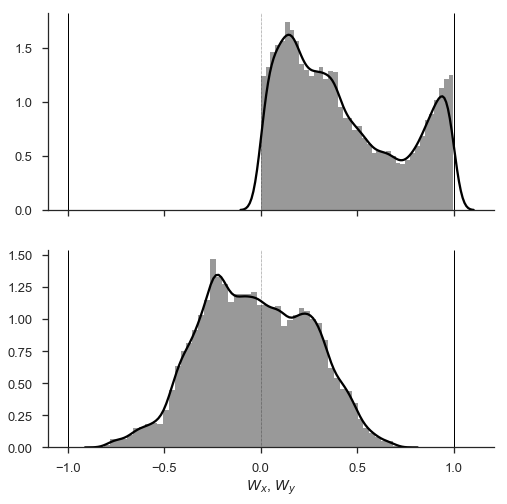

In [400]:
import seaborn as sns
from ccpy.plot import get_figsize

nrows, ncols = 2, 1
size, aspect = 4, 2.
figsize = get_figsize(nrows, ncols, size, aspect)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
[ax1, ax2] = axs

sns.distplot(Wx_sample[~np.isnan(Wx_sample)], ax=ax1, color='k')
sns.distplot(Wy_sample[~np.isnan(Wy_sample)], ax=ax2, color='k')

for ax in axs:
    ylo, yhi = ax.get_ylim()
    ax.vlines([-1, 0, 1], ylo, yhi, linestyles=['solid', 'dotted', 'solid'],
               linewidths=[1, 0.5, 1])

ax2.set_xlabel("$W_x$, $W_y$")
sns.despine(fig)

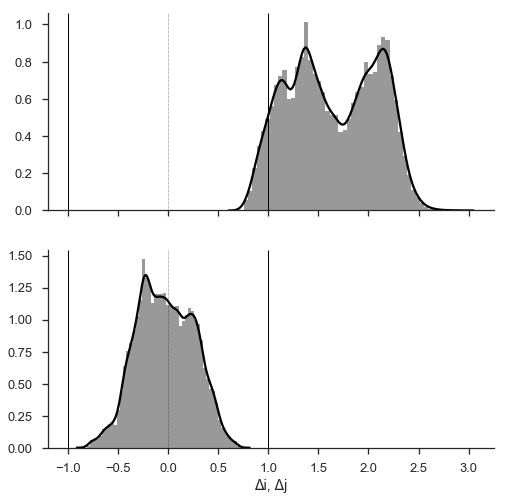

In [403]:
import seaborn as sns
from ccpy.plot import get_figsize

nrows, ncols = 2, 1
size, aspect = 4, 2.
figsize = get_figsize(nrows, ncols, size, aspect)

fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True)
[ax1, ax2] = axs

sns.distplot(Δi_sample[~np.isnan(Δi_sample)], ax=ax1, color='k')
sns.distplot(Δj_sample[~np.isnan(Δj_sample)], ax=ax2, color='k')

for ax in axs:
    ylo, yhi = ax.get_ylim()
    ax.vlines([-1, 0, 1], ylo, yhi, linestyles=['solid', 'dotted', 'solid'],
               linewidths=[1, 0.5, 1])

ax2.set_xlabel("Δi, Δj")
sns.despine(fig)